![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 1. Wyjaśnialne uczenie maszynowe - ćwiczenia

## Zadanie 1.

Wczytaj zbiór `titanic2.csv`. Opis zbioru poniżej:

Nazwa zmiennej | Opis 
:------------- | :--------------------------------------
Pclass         | Passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
Survived       | Survival (0 = No; 1 = Yes)
name           | Passenger name
sex            | Passenger gender
age            | Passenger age
sibsp          | Number of Siblings/Spouses Aboard of a Passenger
parch          | Number of Parents/Children Aboard of a Passenger
ticket         | Ticket Number
fare           | Passenger Fare (British pound)
cabin          | Cabin Number
embarked       | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat           | Lifeboat
body           | Body Identification Number
home.dest      | Home/Destination

Wykonaj następujące polecenia:

* przygotuj zbiór do analizy (sprawdź czy są braki danych, usuń nieprzydatne zmienne oraz zmienne stanowiące przeciek informacji, zamień zmienne nominalne na binarne etc.) oraz podziel zbiór na treningowy i testowy. Przygotuj obiekty `features` i `target`.

In [1]:
# Podstawowe pakiety
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia graficzne
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline

# Machine Learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score

# Modele ML
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from helpers import run_xgb

# Selekcja zmiennych
from boruta import BorutaPy
from sklearn.feature_selection import RFE

# XAI
from pdpbox import pdp, info_plots
from lime import lime_tabular
import dalex as dx

In [2]:
import pandas as pd
import numpy as np

titanic = pd.read_csv('data/titanic2.csv', sep=';', decimal=',')
titanic.drop(columns = ['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest'], inplace=True)
titanic = pd.get_dummies(titanic, columns = ['sex', 'embarked'], drop_first=True)
titanic = titanic.dropna()

features = titanic.columns.tolist()
features.remove('survived')
print(features)
target = 'survived'
display(titanic.head())

# Podzielenie zbioru na część treningową i testową
X_tr, X_te, y_tr, y_te = train_test_split(titanic[features], titanic['survived'], test_size=0.2, random_state=1, shuffle=True, stratify=titanic['survived'])

print(X_tr.shape, X_te.shape)

['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q', 'embarked_S']


,pclass,survived,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,0,0,1
1,1,1,0.9167,1,2,151.5500,1,0,1
2,1,0,2.0000,1,2,151.5500,0,0,1
3,1,0,30.0000,1,2,151.5500,1,0,1
4,1,0,25.0000,1,2,151.5500,0,0,1


(836, 8) (209, 8)


* wykonaj model przewidujący przeżycie pasażerów na statku Titanic wykorzystując logit, lasy losowe, xgboost oraz dowolne inne znane Ci modele (np. SVM lub KNN). Policz metryki dopasowania dla tych modeli (Accuracy, ROCAUC, Precyzję, Czułość). Dodatkowo możesz spróbować narysować krzywą ROC (można to dość prosto zrobić wykorzystując pakiet Dalex - wyszukaj w Internecie odpowiednie polecenia). Dla modeli opartych o drzewa decyzyjne (z ang. *tree based*) policz różne rankingi ważności zmiennych. Czy wiesz jak stworzyć podobny ranking dla pozostałych metod?

In [3]:
lr = LogisticRegression(penalty='none', solver='newton-cg')
rf = RandomForestClassifier(n_estimators=150, max_depth=4, max_features='sqrt')
xgb = XGBClassifier(tree_method="hist", eval_metric=roc_auc_score, gamma=1, n_estimators=300, max_depth = 4,
                    colsample_bytree=0.8, importance_type="total_gain", reg_lambda=16, subsample=0.7)

In [4]:
lr.fit(X_tr, y_tr)
rf.fit(X_tr, y_tr)
xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=False, early_stopping_rounds=50)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x0000025CF1F1EA60>,
              gamma=1, gpu_id=-1, importance_type='total_gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=16, scale_pos_weight=1, subsample=0.7,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [5]:
pred_lr_tr = lr.predict_proba(X_tr)[:,1]
pred_rf_tr = rf.predict_proba(X_tr)[:,1]
pred_xgb_tr = xgb.predict_proba(X_tr)[:,1]

In [6]:
pred_lr_te = lr.predict_proba(X_te)[:,1]
pred_rf_te = rf.predict_proba(X_te)[:,1]
pred_xgb_te = xgb.predict_proba(X_te)[:,1]

In [7]:
print('lr:', roc_auc_score(y_tr, pred_lr_tr), roc_auc_score(y_te, pred_lr_te))
print('rf:', roc_auc_score(y_tr, pred_rf_tr), roc_auc_score(y_te, pred_rf_te))
print('xgb:', roc_auc_score(y_tr, pred_xgb_tr), roc_auc_score(y_te, pred_xgb_te))

lr: 0.8535081800317257 0.8379981024667931
rf: 0.8840678788739731 0.8255692599620494
xgb: 0.9229141510997466 0.8592504743833017


In [8]:
tab = pd.DataFrame(sorted(list(zip(features, rf.feature_importances_)), key = lambda x: x[1], reverse=True)).rename(columns={0: 'feature', 1:'MDI'})
tab.head(10)

,feature,MDI
0,sex_male,0.468672
1,fare,0.160620
2,pclass,0.153824
3,age,0.080694
4,parch,0.058432
5,sibsp,0.032833
6,embarked_S,0.031565
7,embarked_Q,0.013360


In [9]:
# (obliczenia trwają kilka minut)
r = permutation_importance(lr, X_tr, y_tr, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
        print(f"{features[i]:<8} {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")

sex_male 0.209 +/- 0.011
pclass   0.054 +/- 0.010
age      0.010 +/- 0.007
embarked_Q 0.009 +/- 0.003
fare     0.001 +/- 0.001
sibsp    -0.001 +/- 0.003
embarked_S -0.002 +/- 0.005
parch    -0.002 +/- 0.002


In [10]:
# (obliczenia trwają kilka minut)
r = permutation_importance(rf, X_tr, y_tr, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
        print(f"{features[i]:<8} {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")

sex_male 0.193 +/- 0.009
pclass   0.031 +/- 0.007
age      0.023 +/- 0.006
parch    0.016 +/- 0.004
fare     0.011 +/- 0.004
sibsp    0.008 +/- 0.002
embarked_S 0.006 +/- 0.004
embarked_Q 0.002 +/- 0.002


In [11]:
# (obliczenia trwają kilka minut)
r = permutation_importance(xgb, X_tr, y_tr, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
        print(f"{features[i]:<8} {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")

sex_male 0.195 +/- 0.009
age      0.077 +/- 0.008
pclass   0.064 +/- 0.007
fare     0.043 +/- 0.005
sibsp    0.016 +/- 0.004
embarked_Q 0.008 +/- 0.002
embarked_S 0.006 +/- 0.004
parch    0.004 +/- 0.003


* Dla kilku najważniejszych (i najlepiej ciągłych) zmiennych policz oczekiwane odpowiedzi dla różnych modeli na podstawie historycznych danych. Następnie dla najlepszego modelu policz kontrfaktyczne wykresy PDP, ALE, ICE (dla tych samych zmiennych).  Zinterpretuj wyniki. Zadanie wykonaj dla zbioru testowego, jeśli okaże się za mały, wygeneruj prognozy dla całego zbioru. Czy między zmiennymi zachodzą ciekawe interakcje?

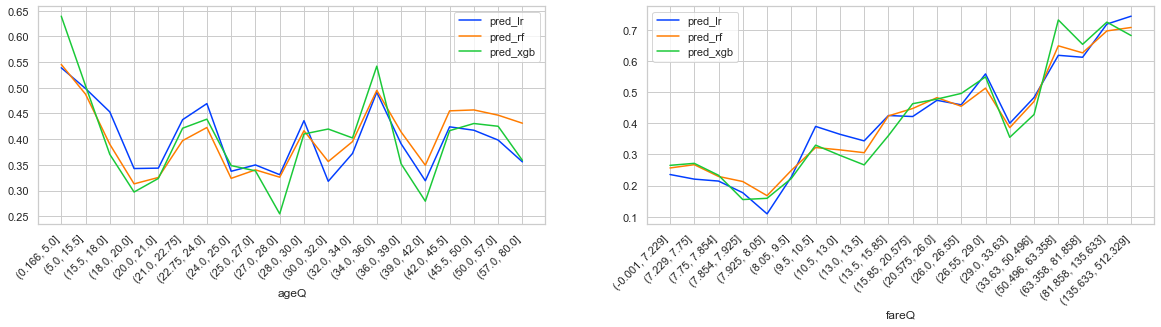

In [14]:
kwantyle = 20

X_tr['pred_lr'] = pred_lr_tr
X_tr['pred_rf'] = pred_rf_tr
X_tr['pred_xgb'] = pred_xgb_tr

X_tr['ageQ'] = pd.qcut(X_tr['age'], q=20, duplicates='drop')
X_tr['fareQ'] = pd.qcut(X_tr['fare'], q=20, duplicates='drop')

# Propozycja druga - przedziały kwantylowe (tzw. półdecyle)
fig, axes = plt.subplots(ncols=2, figsize=(20, 4))
for i, feat in enumerate(['ageQ', 'fareQ']):
    tab = X_tr.groupby(feat).agg({'pred_lr':'mean','pred_rf':'mean','pred_xgb':'mean'})
    tab.plot(ax=axes[i])
    axes[i].set_xticks(np.arange(0, len(tab.index)), tab.index, rotation = 45, ha='right')

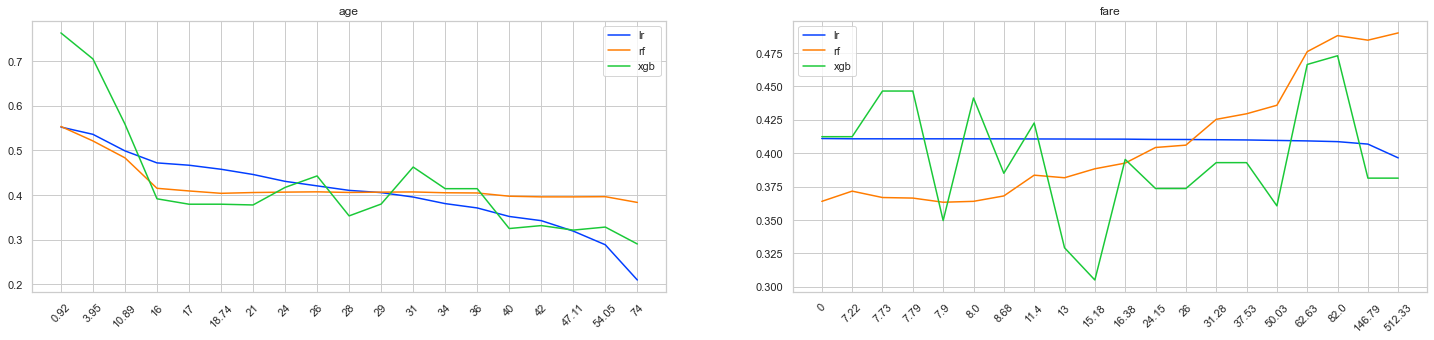

In [19]:
fig, axes = plt.subplots(ncols=2,figsize = (25, 5))
number=20

for i, x in enumerate(['age', 'fare']):
    for ai_str, ai in zip(['lr', 'rf', 'xgb'], [lr, rf, xgb]):
        model = pdp.pdp_isolate(model=ai, dataset=X_te,model_features=features, feature=x, num_grid_points=number)
        number = len(model.display_columns)
        axes[i].plot(range(number), model.pdp, label = ai_str)
        axes[i].set_title(x)
        axes[i].set_xticks(range(number))
        axes[i].set_xticklabels(model.display_columns, rotation=45)
        axes[i].legend()
        number=20

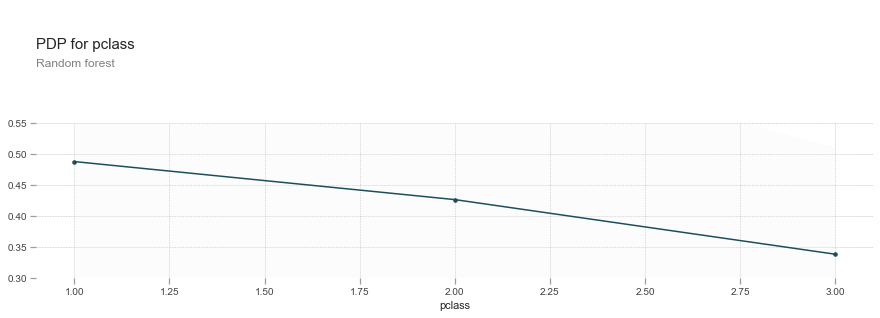

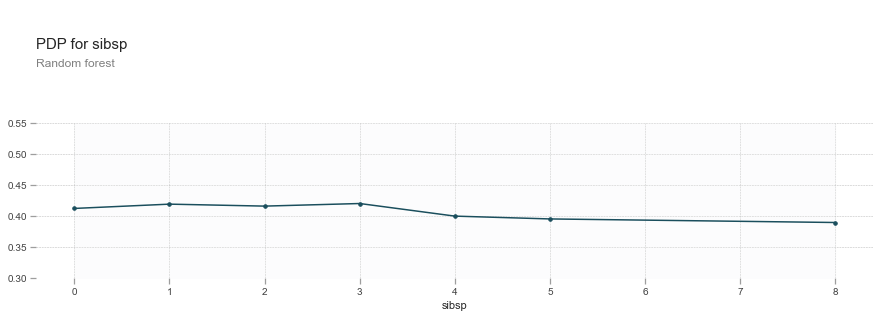

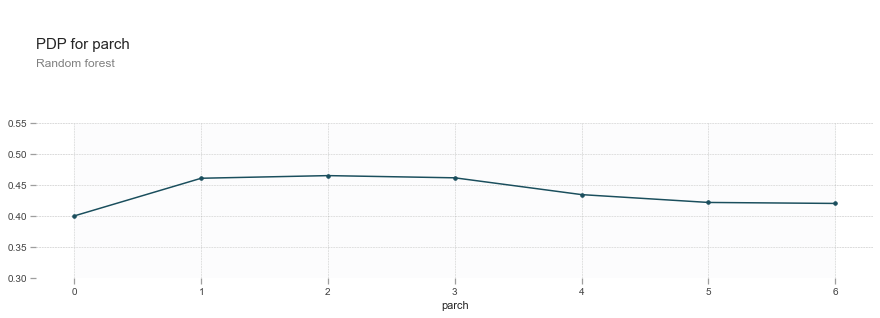

In [31]:
plot_params = {
    # plot title and subtitle
    'title': 'PDP for Age', 'title_fontsize': 15, 'subtitle_fontsize': 12, 'subtitle':'Random forest',
    # color for contour line
    'contour_color':  'white', 'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis', 'line_cmap': 'white',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.2,
    'fill_color': '#f2f4f5',
    'fill_alpha': 0.2,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}

for feat in ['pclass', 'sibsp', 'parch']:
    plot_params['title'] = f'PDP for {feat}'
    model = pdp.pdp_isolate(model=rf, dataset=X_tr, model_features=features, feature=feat, cust_grid_points=X_tr[feat].unique())
    fig, axes = pdp.pdp_plot(pdp_isolate_out=model, feature_name=feat, center=False, x_quantile=False, plot_params=plot_params, figsize = (15, 5),show_percentile=True)
    plt.ylim(0.3, 0.55)

In [32]:
X_te.iloc[0]

pclass         3.000
age           44.000
sibsp          0.000
parch          0.000
fare           7.925
sex_male       1.000
embarked_Q     0.000
embarked_S     1.000
Name: 1233, dtype: float64

In [34]:
X_te.loc[818]

pclass         3.0000
age           16.0000
sibsp          0.0000
parch          0.0000
fare           7.7333
sex_male       0.0000
embarked_Q     1.0000
embarked_S     0.0000
Name: 818, dtype: float64

In [39]:
obs = pd.DataFrame({'pclass': 3.0000, 'age': 16.0000, 'sibsp': 0.0000, 'parch': 0.0000, 'fare' : 7.7333, 'sex_male' : 0.0000, 'embarked_Q' : 1.0000, 'embarked_S' : 0.0000}, index = [0])

* Wybierz z danych (ze zbioru testowego):
    - 2 pasażerów, którzy przeżyli i model prognozuje ten fakt poprawnie,
    - 2 pasażerów, którzy przeżyli i model prognozuje ten fakt błędnie,
    - 2 pasażerów, którzy nie przeżyli i model prognozuje ten fakt poprawnie,
    - 2 pasażerów, którzy nie przeżyli i model prognozuje ten fakt błędnie.
    
Nastepnie na podstawie wykresu Breakdown, wartości Shapleya, lokalnych surogatów (LIME) oraz wykresów `What-if` (dla najważniejszych zmiennych) spróbuj zastanowić się, dlaczego model popełnia w niektórych przypadkach błędy.    

* dla wybranych obserwacji, dla najważniejszych zmiennych policz wykresy What-If. Czy okazują się pomocne w odpowiedzi na pytanie, czemu błędnie prognozujemy? 

* Spróbuj poprawić model regresji logistycznej za pomocą zmiennych przekształconych modelem lasów losowych.

# Zadanie 2.

Wczytaj zbiór apartments. Wykonaj następujące polecenia:

In [3]:
import dalex as dx
import pandas as pd
import numpy as np

data = dx.datasets.load_apartments()
data.head()

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga
4,3517,1995,93,7,3,Ochota
5,3013,1992,144,6,5,Mokotow


* przygotuj zbiór do analizy (sprawdź czy są braki danych, usuń nieprzydatne zmienne, zamień zmienne nominalne na binarne etc.) oraz podziel zbiór na treningowy i testowy. Przygotuj obiekt `features` i `target`.

* wykonaj model prognozujący ceny nieruchomości (`m2_price`) wykorzystując regresję liniową, lasy losowe, xgboost oraz dowolne inne znane Ci modele (np. SVM lub KNN). Policz metryki dopasowania dla tych modeli (RMSE, MAE, MAPE, RMSLE). Dla modeli opartych o drzewa decyzyjne (z ang. *tree based*) policz różne rankingi ważności zmiennych. Czy wiesz jak stworzyć podobny ranking dla pozostałych metod?

* Wykorzystując pakiet Dalex, dokonaj analizy rozkładu reszt w różnych modelach. Zinterpretuj wyniki

* Wykonaj wykresy PDP, ALE, ICE i porównaj sposób działania zmiennych w różnych modelach. Zinterpretuj wyniki. Czy między zmiennymi zachodzą ciekawe interakcje?

Sprawdź mechanizm generowania prognoz dla kilku obserwacji z różnych obszarów rozkładu zmiennej objaśnianej (np. lewy ogon, środek, prawy ogon) za pomocą wykresu Breakdown, wartości Shapleya, lokalnych surogatów (LIME) oraz wykresów `What-if`. Czy w różnych półkach cenowych zmienne oddziałują odmiennie?

* spróbuj poprawic model regresji liniowej wykorzystując do tego zmienne przekształcone za pomocą modelu lasów losowych.